# Twitter trolls - how Russia meddles with western democracies


## Abstract
Over the last several years there has been an attempt from Russian trolls to spread propaganda and fake news over social media in order to spread political ideas among the general population both nationally and internationally. Can these attempts be regarded as undermining the democracy of the affected countries?

In this project we are going to analyze a great number of these russian tweets and look into their motivations for this meddling. We will mainly look into their overall political goals in the US, and examine how these goals change over time. Have the trolls achieved their goals? We will also look into how the trolls operate and organize themselves, trying to find patterns in the madness. Such patterns can hopefully help the general population to indicate that a tweet is originating from a troll. As the Russian efforts are increasing every year, a solution is needed to defend the democracy.

### Imports used in this notebook


In [2]:
import os
print(os.environ["JAVA_HOME"])
print(os.environ["SPARK_HOME"])

/Library/Java/JavaVirtualMachines/jdk1.8.0_121.jdk/Contents/Home
/Users/Hakon/Documents/spark


In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import scipy as sp
from pyspark.sql import *
import matplotlib.pyplot as plt
from statistics import median 
#from langdetect import detect
%matplotlib inline
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
from matplotlib.pyplot import figure
#import pyspark.sql.SQLContext
from ipywidgets import *
import pyspark.sql.functions as func
import seaborn as sns
import plotly
plotly.tools.set_credentials_file(username='haakonms', api_key='oYz1dEh5JqxsGGF4EMQd')
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
import warnings
#import findspark
#findspark.init()
warnings.filterwarnings('ignore')
#Want to ignore this since we had the same error running over and over regarding to whether use loc or make a copy. In our notebook the difference does not matter.

spark = SparkSession.builder.getOrCreate()

Py4JError: An error occurred while calling None.org.apache.spark.api.python.PythonAccumulatorV2. Trace:
py4j.Py4JException: Constructor org.apache.spark.api.python.PythonAccumulatorV2([class java.lang.String, class java.lang.Integer]) does not exist
	at py4j.reflection.ReflectionEngine.getConstructor(ReflectionEngine.java:179)
	at py4j.reflection.ReflectionEngine.getConstructor(ReflectionEngine.java:196)
	at py4j.Gateway.invoke(Gateway.java:237)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)



# 1) Preprocessing the data
The data sets are of different shape and quality. The first one, provided by two researchers from Clemson University has already been preprocessed a bit. The second one is still quite raw, even though it has certain features as for example language. We have been cleaning some of it, and also processing and enriching to make new data frames that we want to use in our analysis.

## 1.1) The first dataset - IRA tweets from Kaggle.
The first dataset has the following features:
- external_author_id | An author account ID from Twitter 
- author | The handle sending the tweet
- content | The text of the tweet
- region | A region classification based on following criterias:
     - 1. Geographical coordinates
     - 2. Location listed in the user's profile
     - 3. Time zone set by the user in their Twitter account settings.
- language | The language of the tweet
- publish_date | The date and time the tweet was sent
- harvested_date | The date and time the tweet was collected by Social Studio
- following | The number of accounts the handle was following at the time of the tweet
- followers | The number of followers the handle had at the time of the tweet
- updates | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
- post_type | Indicates if the tweet was a retweet or a quote-tweet
- account_type | Specific account theme, as coded by Linvill and Warren
- retweet | A binary indicator of whether or not the tweet is a retweet
- account_category` | General account theme, as coded by Linvill and Warren
- new_june_2018 | A binary indicator of whether the handle was newly listed in June 2018


### 1.1.1) Loading the first dataset
We loaded the 9 files into a unified dataframe. We decided to use pandas, since the dataset is not too large, and especially with the fact that we will be focusing on subsets of these tweets.

In [6]:
zip_file = ZipFile('russian-troll-tweets.zip')
data = pd.DataFrame()
for i in range(1,9):
    data = data.append(pd.read_csv(zip_file.open("IRAhandle_tweets_"+str(i)+".csv")))
first_set_data=data.reset_index()
first_set_data.tail(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
2935811,378290,1.513801e+09,YOUJUSTCTRLC,They'll say some shit anonymously like a cowar...,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3007,RETWEET,left,0,1,LeftTroll
2935812,378291,1.513801e+09,YOUJUSTCTRLC,Mr. Brown knees https://t.co/LmAiHCnFlz,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3006,RETWEET,left,0,1,LeftTroll
2935813,378292,1.513801e+09,YOUJUSTCTRLC,"Like, you want somebody who follows you regula...",United States,English,1/7/2017 7:47,1/7/2017 7:47,2655,2724,3005,RETWEET,left,0,1,LeftTroll
2935814,378293,1.513801e+09,YOUJUSTCTRLC,"If you wanna ask me something, ask it here so ...",United States,English,1/7/2017 7:48,1/7/2017 7:48,2655,2724,3008,RETWEET,left,0,1,LeftTroll
2935815,378294,1.513801e+09,YOUJUSTCTRLC,And there he is again ... Inside the KGB Playb...,United States,English,1/8/2017 1:56,1/8/2017 1:57,2655,2724,3013,RETWEET,left,0,1,LeftTroll


In [7]:
first_set_data.head(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


### 1.1.2) Cleaning and filtering the first dataset
The first dataset is pretty clean as it is, but it contains some nan-values and duplicates. We are also working with some parts of the data set, so it's filtered a bit as well.

#### 1.1.2.1) Dropping the data we don't want.

The index column is unnecessary as pandas assigns an index anyway. "new_june_2018" and "harvested_date" does not add anything that we are going to use, and we already have a "post_type", so we don't need a binary indicator for that.

In [8]:
data1_drop_step = first_set_data.drop(columns=["retweet", "index", "new_june_2018", "harvested_date"]) 

#### 1.1.2.2) Filtering out the english tweets.
After inspecting some of the tweets we concluded that a lot of the language stamps do not match the actual tweets. For instance, most of the tweets labeled to our mothertongue Norwegian was English. The same went for different languages, such as those of neighbouring countries like Danish and Swedish. For this reason we decide to discard all tweets in other languages than english, in order to avoid confusion. We could have included tweets in other languages of which we have some knowledge of, we decide not to as we have limited knowledge of the political climate in these countries. The labeling of english tweets are also better, and our decision also helps keeping the scope of the project limited.

In [9]:
data1_filter_english = data1_drop_step.loc[data1_drop_step['language'] == "English"]
data1_filter_english.head(3)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,RightTroll


#### 1.1.2.3) Cleaning empty data and duplicates, plus some small format changes.

In [10]:
isna_columns = data1_filter_english.isna().any(axis=0)
column_nan_list = isna_columns[isna_columns== True].index.tolist()
for x in column_nan_list:
    print(x, ":", data1_filter_english[x].isnull().sum())
    #clean

content : 1
region : 1145
post_type : 1270631
account_type : 354


For content we are going to eliminate the only empty one. For region and account_type, we are going to change it to an string that shows that it is unknown. When the post_type is nan, it only means that it is a original tweet so we change it to that.

In [11]:
data1_filter_english["account_type"] = data1_filter_english["account_type"].fillna("?") #gjøre om right til Right?
data1_filter_english["region"] = data1_filter_english["region"].fillna("Unknown")
data1_filter_english["content"] = data1_filter_english["content"].dropna()
data1_filter_english["post_type"] = data1_filter_english["post_type"].fillna("ORIGINAL")
#clea


In [12]:
#We also found out that there are two account_types that are equal. "Right" and "right". T
data1_filter_english["account_type"] = data1_filter_english["account_type"].str.lower()


The time stamps in this dataset is in string format. For further calculations, it would be better to have them as datetime.

In [13]:
data1_filter_english["publish_date"] = pd.to_datetime(data1_filter_english["publish_date"], format='%m/%d/%Y\n%H:%M')

In [14]:
data1_dup_step = data1_filter_english.drop_duplicates()
duplicates_number = data1_filter_english.shape[0]-data1_dup_step.shape[0] 
#drop duplicates in everything
dropdup_specific = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])
duplicates_except_timestamp = data1_dup_step.shape[0]-dropdup_specific.shape[0]
print("Full duplicates:", duplicates_number, "\nDuplicates in all forms except time stamp:", duplicates_except_timestamp)

Full duplicates: 13692 
Duplicates in all forms except time stamp: 358


In [15]:
data_sub_dropped = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])

The creators of this dataset also states that they did not sample anything in 2018. There are still a few tweets that have slipped in with the date tag being 2018. These are in so few numbers so we limit our data set to the period before that.

In [16]:
data1 = data_sub_dropped.loc[data_sub_dropped["publish_date"] < "2018-01-01"]
data1.head(5)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,1050,9645,246,RETWEET,right,RightTroll


This dataset is ready to go!

## 1.2) The second dataset
Twitter released nine million tweets that they had traced to russian troll accounts on 17th October 2018. This dataset was in a much more raw format than the one provided on Kaggle, and consisted of eigth csv-files. Four of them was tweets from the Iranian agency, who also does this on a major scale. The other four was tweets produced by the IRA:
- rus_troll_user.csv : Contains user specific features. 
- rus_troll_tweet_text.csv: Contains text and language of the given tweet.
- rus_troll_tweet_metadata.csv: Contains features that are user specific, but may change tweet to tweet.
- rus_troll_tweet_stats.csv: Contains other tweet features like retweet count, like count, if it is a retweet, quote tweet etc.

The whole dataset can be downloaded at this link: https://drive.google.com/open?id=1GBsVXYvPrGcYI-wR4mWGO39fly1TMqjO.

### 1.2.1) Loading the second dataset
We loaded the second dataset in as pandas data frames as well. After that we merged all of them together and created a new one for our preliminary analysis. For our research question we used the original format of it as mentioned in the markdown cell under.

In [17]:
zip_file_new = ZipFile("New_russian_tweets.zip")
new_text = pd.read_csv(zip_file_new.open("rus_troll_tweet_text.csv"))
new_metadata = pd.read_csv(zip_file_new.open("rus_troll_tweet_metadata.csv")).drop(columns=["latitude","longitude","tweet_client_name"])
new_user = pd.read_csv(zip_file_new.open("rus_troll_user.csv")).drop(columns=["user_display_name","user_screen_name","user_profile_description","user_profile_url"])
new_stats = pd.read_csv(zip_file_new.open("rus_troll_tweet_stats.csv")).drop(columns=["poll_choices","urls"])

When we first worked with the second dataset for milestone 2, we were not sure what to do with it. When performing further analysis after milestone 2 we wanted to use the original files in spark, so we wrote them to parquet and loaded them back.

In [629]:
#data2.to_parquet('data2.parquet.gzip', compression='gzip')
#new_stats.to_parquet('stats.parquet.gzip', compression='gzip')
#new_tweets.to_parquet('tweets.parquet.gzip', compression='gzip')
#new_text.to_parquet('text.parquet.gzip', compression='gzip')
#new_user.to_parquet('user.parquet.gzip', compression='gzip')
#This cell need to be run if you don't have these files.

In [18]:
#tweets = spark.read.parquet('tweets.parquet.gzip')
text = spark.read.parquet('text.parquet.gzip')
stats = spark.read.parquet('stats.parquet.gzip')
users = spark.read.parquet('user.parquet.gzip')


Py4JJavaError: An error occurred while calling o21.parquet.
: java.lang.IllegalArgumentException
	at org.apache.xbean.asm5.ClassReader.<init>(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.<init>(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.<init>(Unknown Source)
	at org.apache.spark.util.ClosureCleaner$.getClassReader(ClosureCleaner.scala:46)
	at org.apache.spark.util.FieldAccessFinder$$anon$3$$anonfun$visitMethodInsn$2.apply(ClosureCleaner.scala:449)
	at org.apache.spark.util.FieldAccessFinder$$anon$3$$anonfun$visitMethodInsn$2.apply(ClosureCleaner.scala:432)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.mutable.HashMap$$anon$1$$anonfun$foreach$2.apply(HashMap.scala:103)
	at scala.collection.mutable.HashMap$$anon$1$$anonfun$foreach$2.apply(HashMap.scala:103)
	at scala.collection.mutable.HashTable$class.foreachEntry(HashTable.scala:230)
	at scala.collection.mutable.HashMap.foreachEntry(HashMap.scala:40)
	at scala.collection.mutable.HashMap$$anon$1.foreach(HashMap.scala:103)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at org.apache.spark.util.FieldAccessFinder$$anon$3.visitMethodInsn(ClosureCleaner.scala:432)
	at org.apache.xbean.asm5.ClassReader.a(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.b(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.accept(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.accept(Unknown Source)
	at org.apache.spark.util.ClosureCleaner$$anonfun$org$apache$spark$util$ClosureCleaner$$clean$14.apply(ClosureCleaner.scala:262)
	at org.apache.spark.util.ClosureCleaner$$anonfun$org$apache$spark$util$ClosureCleaner$$clean$14.apply(ClosureCleaner.scala:261)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at org.apache.spark.util.ClosureCleaner$.org$apache$spark$util$ClosureCleaner$$clean(ClosureCleaner.scala:261)
	at org.apache.spark.util.ClosureCleaner$.clean(ClosureCleaner.scala:159)
	at org.apache.spark.SparkContext.clean(SparkContext.scala:2299)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2073)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.mergeSchemasInParallel(ParquetFileFormat.scala:611)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.inferSchema(ParquetFileFormat.scala:241)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$8.apply(DataSource.scala:202)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$8.apply(DataSource.scala:202)
	at scala.Option.orElse(Option.scala:289)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:201)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:392)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:239)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:227)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:622)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:844)


### 1.2.2) Cleaning, merging and filtering the second dataset

The data set did not have suitable column names, so we manually created column names under. We also merged all of the different files together, since we had dropped a bunch of columns which we found unnecessary for the first analysis.

In [14]:
new_english_text = new_text[new_text["tweet_language"]=="en"].drop(columns=["tweet_language"])
#To create a data frame that only had english tweets in it.
new_metadata.columns=["tweetid","following","followers"]

In [15]:
merge_step = pd.merge(new_english_text, new_metadata, on='tweetid')
new_tweets = pd.merge(merge_step,new_stats.filter(["tweetid","userid","tweet_time"]) , on='tweetid')

In the first data set we had a column that showed whether the tweet was original, retweet etc. The second set had not the same features, so we wanted to create this. 

In [16]:
#we sort out retweets from one set
retweets = new_stats[new_stats["is_retweet"]==True]
#Select retweets in tweet set
retweets = new_tweets[new_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
#add extra column stating that this is a retweet
retweets["post_type"] ="RETWEET"
#We follow same procedure for quote tweets, after finding tweets with quoted tweetid
quote_tweets = new_stats[np.isfinite(new_stats['quoted_tweet_tweetid'])]
quote_tweets = new_tweets[new_tweets["tweetid"].isin(quote_tweets["tweetid"].tolist())]
#we only regard a retweeted quotetweet as a retweet
quote_tweets = quote_tweets[~quote_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
quote_tweets["post_type"] = "QUOTE_TWEET"
unoriginal_tweets = quote_tweets.append(retweets)
#we label all other tweets as original tweets
orig_tweets= new_tweets[~new_tweets["tweetid"].isin(unoriginal_tweets["tweetid"])]
orig_tweets["post_type"] = "ORIGINAL"
data2 = unoriginal_tweets.append(orig_tweets)
data2.head(5)

The second dataset now have the following features: 
- tweetid | The ID of the tweet.
- tweet_text | The text of the tweet 
- tweet_time | The date and time the tweet was sent
- following | The number of accounts the handle was following at the time of the tweet
- followers | The number of followers the handle had at the time of the tweet
- user_id | The unique ID of the user who posted the tweet.
- post_type | Indicates if the tweet was a retweet, original tweet or a quote-tweet.


# 2) An overview of the data.

## 2.1) Enriching the data

We want to enrich the data set by making some new frames for possible use, where we also are going to add some new features. As follows:

#### Authors
There are 2.1 million english tweets in this dataset but only a number of unique usernames. We want to take a look at who the unique authors are, what category they are and how they became so prominent. 

In [597]:
authors_step = data1[["external_author_id", "author", "account_category"]].drop_duplicates(subset = ["external_author_id", "author"])
authors = authors_step[authors_step.account_category != "NonEnglish"]
authors["tweet_count"] = data1.groupby('author')['author'].transform('count')
authors["peak_followers"] = data1.groupby(['author'], sort=True)['followers'].transform("max")
rtcountstep = data1[data1["post_type"] == "RETWEET"]["author"].value_counts().to_frame()
authors = rtcountstep.merge(authors, right_on = "author", left_on = rtcountstep.index, how= "right").fillna(0)
authors = authors.drop(columns="author_y").drop_duplicates(subset = ["tweet_count", "author", "peak_followers", "author_x"])
authors = authors.rename(index=str, columns={"author_x": "retweet_count"})



In [598]:
most_pop_authors = authors.sort_values(by = "peak_followers", axis = 0)
most_pop_authors.tail(10)

,author,retweet_count,external_author_id,account_category,tweet_count,peak_followers
384,BLACKNEWSOUTLET,42.0,4.301963e+09,LeftTroll,2482,40788
181,THEFOUNDINGSON,951.0,4.508631e+09,RightTroll,8798,42000
253,USA_GUNSLINGER,281.0,4.332741e+09,RightTroll,3234,43895
292,SOUTHLONESTAR,151.0,4.355797e+09,RightTroll,3647,53782
212,CRYSTAL1JOHNSON,624.0,4.437234e+09,LeftTroll,8037,56725
495,ELEVEN_GOP,20.0,4.218156e+09,RightTroll,101,59100
512,TODAYNYCITY,17.0,2.752678e+09,NewsFeed,18478,62088
236,PAMELA_MOORE13,361.0,4.272871e+09,RightTroll,6197,70734
215,JENN_ABRAMS,596.0,2.882332e+09,RightTroll,22512,71022
201,TEN_GOP,769.0,4.224730e+09,RightTroll,11274,145244


In [599]:
most_active_authors = authors.sort_values(by = "tweet_count", axis = 0)#.drop_duplicates(subset = ["author", "account_category", "tweet_count", "peak_followers"])
#For some reason, the author with the most tweets appeared with two different author IDs, and every other column was equal.
most_active_authors.tail(5)

,author,retweet_count,external_author_id,account_category,tweet_count,peak_followers
461,TODAYPITTSBURGH,25.0,2.601236e+09,NewsFeed,33376,20608
0,AMELIEBALDWIN,32780.0,1.679279e+09,RightTroll,34307,2860
1361,WORLDNEWSPOLI,0.0,7.890000e+17,RightTroll,35082,3855
1319,SCREAMYMONKEY,0.0,2.943515e+09,NewsFeed,43685,13295
1160,EXQUOTE,0.0,1.964340e+09,Commercial,53158,858


#### Data sets tailored for specific themes.

In [439]:
data1_political = data1[data1["account_category"].isin(["RightTroll","LeftTroll","NewsFeed"])]
data1_political.head(4)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll


#### Data frames with different time periods

Here we will be making some data frames used for the task 3.2. 

The first person that entered and started the primaries was Ted Cruz who officially entered the campaign on th 23th of March 2015. Hillary joined in as the first Democratic candidat on 12th April 2015. Donald Trump announced his candidacy on 16th June 2015.

Therefore it is interesting to look at the amount of tweets from each side, starting with Ted Cruz' announcement. We have been looking into which party that has seen the most meddling, building up to the first primaries, the period between primaries and election and after the election. 

In [21]:
before_primaries1 = data1.loc[data1["publish_date"] < "2016-06-14"]
before_primaries1 = before_primaries1.loc[before_primaries1["publish_date"] > "2015-03-23"]
before_primaries_time1 = before_primaries1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#left
before_primaries_left1 = before_primaries1.loc[before_primaries1["account_type"] == "left"]
bp_left_count1 = before_primaries_left1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#right
before_primaries_right1 = before_primaries1.loc[before_primaries1["account_type"] == "right"]
bp_right_count1 = before_primaries_right1["publish_date"].map(lambda x: str(x)[:7]).value_counts()


After the primaries, things changed. Now it was a run between Clinton and Trump.

In [22]:
after_primaries1 = data1.loc[data1["publish_date"] > "2016-06-14"]
after_primaries_time1 = after_primaries1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#left
after_primaries_left1 = after_primaries1.loc[after_primaries1["account_type"] == "left"]
ap_left_count1 = after_primaries_left1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#right
after_primaries_right1 = after_primaries1.loc[after_primaries1["account_type"] == "right"]
ap_right_count1 = after_primaries_right1["publish_date"].map(lambda x: str(x)[:7]).value_counts()

As mentioned, these frames are made for the analysis in part 3.2, and they will be used and visualized in that part.

## 2.2) Key takeaways from the data.

### 2.2.1 Tweets over time

#### 2.2.1.1 First data set
How many tweets have been tweeted each month since the first russian troll tweet? 

In [453]:
early_tweets1 = data1[data1["publish_date"] < "2014-10"]
early_tweets1.shape[0]

197

Since there are only 197 tweets before october 2014, we remove these from the visualisation since the other numbers are so much higher.

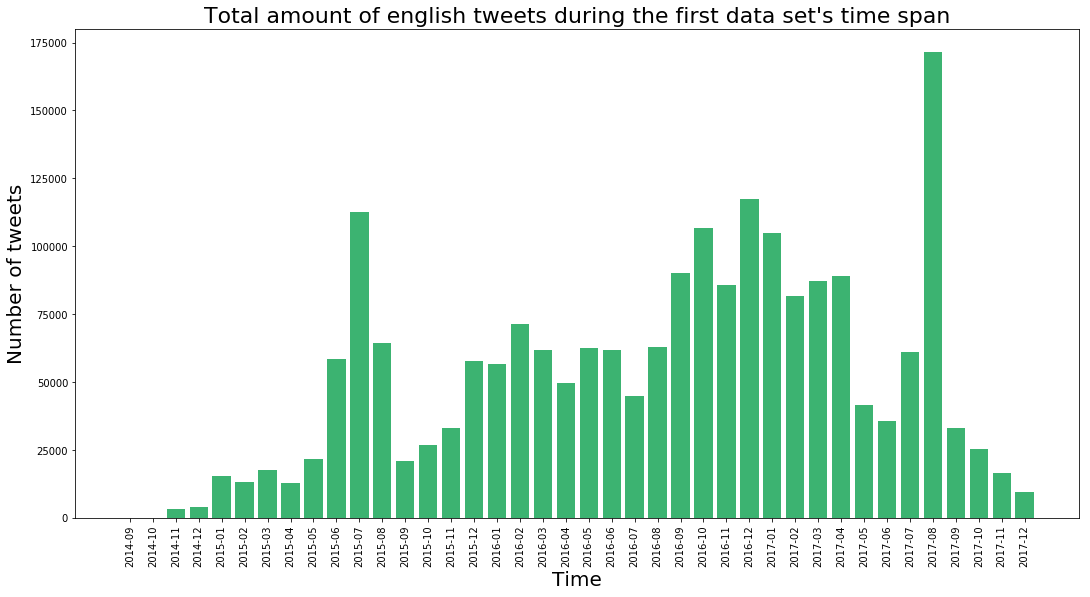

In [503]:
def name_axises(title, xlab, ylab):
    plt.title(title, size=22), plt.xlabel(xlab, size=20), plt.ylabel(ylab, size=20)
# A function for future plotting to save some lines.

data1_timesorted = data1[data1["publish_date"] > "2014-09"].sort_values("publish_date")
data1_month_days = data1_timesorted["publish_date"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data1_month_count = data1_month_days.value_counts()

fig, ax = plt.subplots(1,1 , figsize =(18,9))
over_time_fig = plt.bar(data1_month_count.index, data1_month_count, color = "#3CB371", align="center")
ax.set_xticklabels(data1_month_count.sort_index().index, rotation=90)
name_axises("Total amount of english tweets during the first data set's time span", "Time", "Number of tweets")

The results shows that there were almost no activity until the announcement of the first candidacies in the primaries, with the first visible chart in november 2014. Activity increased in the months just before the election, peaked in december 2016 and decreased a little after that. There were two spikes in July 2015 and August 2017. In August 2017 this was probably because of the Unite The Right rally in Charlottesville, also known as the Charlottesville riots (https://en.wikipedia.org/wiki/Unite_the_Right_rally) (https://buzzfeednews.github.io/2018-08-charlottesville-twitter-trolls/), where e.g. a woman got killed by a white supremacist. 

With the spike in July 2015 we can see in the other dataset that this is not an unique spike but a common number for this period. The first dataset has just not picked so many of the troll tweets before this. 

It is difficult to say whether this represents all the russian troll tweets in this period can amount for the same activity, especially when it comes to the final months of the sample. It could still be viewed as a trend. 

#### 2.2.1.2 Second dataset

In [456]:
early_tweets = data2[data2["tweet_time"] < "2013-11"]
early_tweets.shape[0]

418

As with the first dataset we remove the posts before november 2013 because there are only 418 of them.

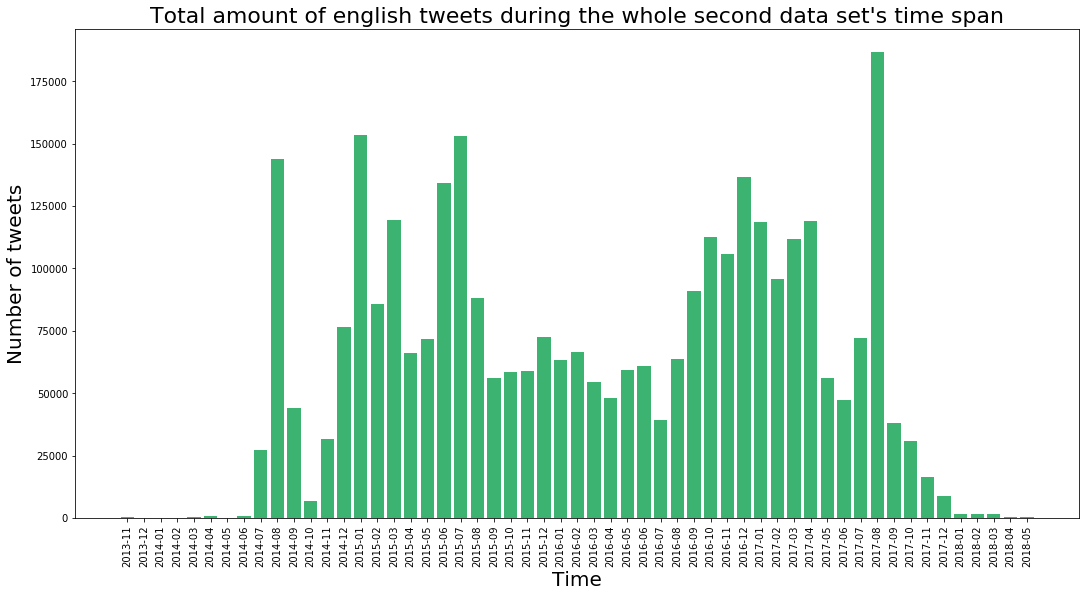

In [533]:
data2_timesorted = data2[data2["tweet_time"] > "2013-10-31"].sort_values("tweet_time")
data2_month_days = data2_timesorted["tweet_time"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data2_month_count = data2_month_days.value_counts()

fig, ax = plt.subplots(1,1 , figsize =(18,9))
over_time_fig = plt.bar(data2_month_count.index, data2_month_count, color = "#3CB371", align="center")
ax.set_xticklabels(data2_month_count.sort_index().index, rotation=90)
name_axises("Total amount of english tweets during the whole second data set's time span", "Time", "Number of tweets")

Almost all the tweets from the first dataset are also in the second dataset. When comparing the two against each other, notice that the labels on thex-axis are different for them. Here we can see that this dataset is quite similar to first one in 2016 and further, but before this point this set has catched up a lot more. For example august 2014 has almost 150000 tweets, and in the first dataset this number is almost non-existent.

These two first visualisations are both tweets with only english language. Under follows a visualisation of all types of language, where we have filtered out the tweets before 2012, since they have a very small fraction of the total tweets and is not visible.

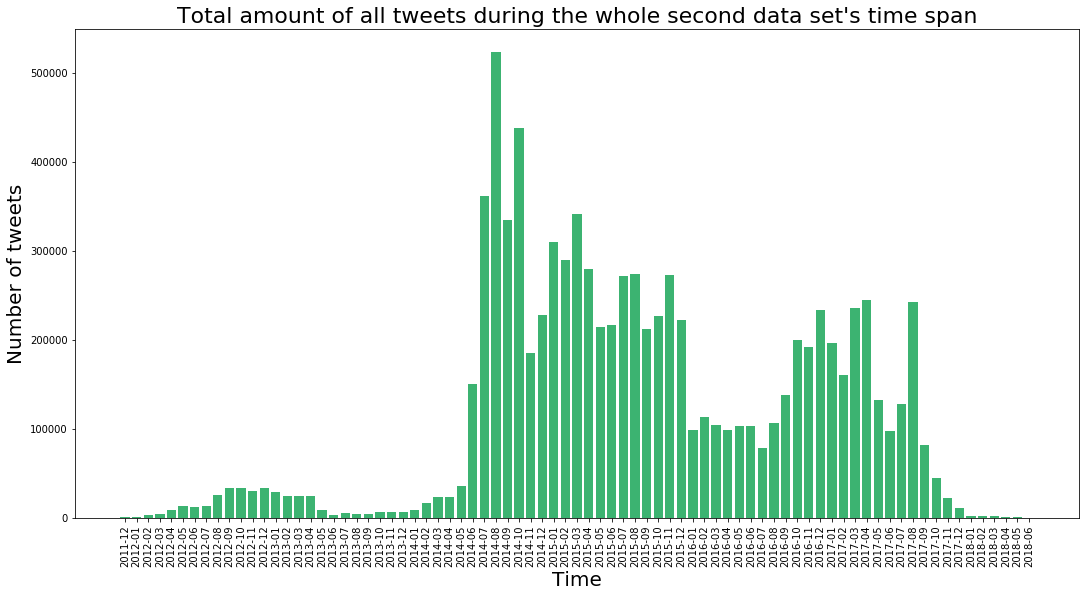

In [527]:
data2_all = new_stats[new_stats["tweet_time"]> "2011-12"].sort_values("tweet_time")
data2all_month_days = data2_all["tweet_time"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data2all_month_count = data2all_month_days.value_counts()

fig, ax = plt.subplots(1,1 , figsize =(18,9))
over_time_fig = plt.bar(data2all_month_count.index, data2all_month_count, color = "#3CB371", align="center")
ax.set_xticklabels(data2all_month_count.sort_index().index, rotation=90)
name_axises("Total amount of all tweets during the whole second data set's time span", "Time", "Number of tweets")

Here we can see that the most tweets actually appeared in 2014. There is a difference here, that most of these tweets are in russian. Before the english tweets really sparked off, there were a lot of russian tweets. This was in the period when the Ukrainian-Russian war/military interference was often mentioned in the media. It may be that the success of the tweeting in this period also started the activity in other regions. This is only speculations, but one thing can be said for sure: The russian trolls came before the english ones. 

### 2.2.2 First appearances of users

We also take a look at when each user accounts had their first entries in the dataset. This may explain why there are more or fewer tweets in the different months of the span of the total number of tweets. 

Disclaimer: This analysis is just of users that at some time have tweeted in the language English. Their account category may be NonEnglish, but they have also at some point had content in english.

#### 2.2.2.1 First dataset

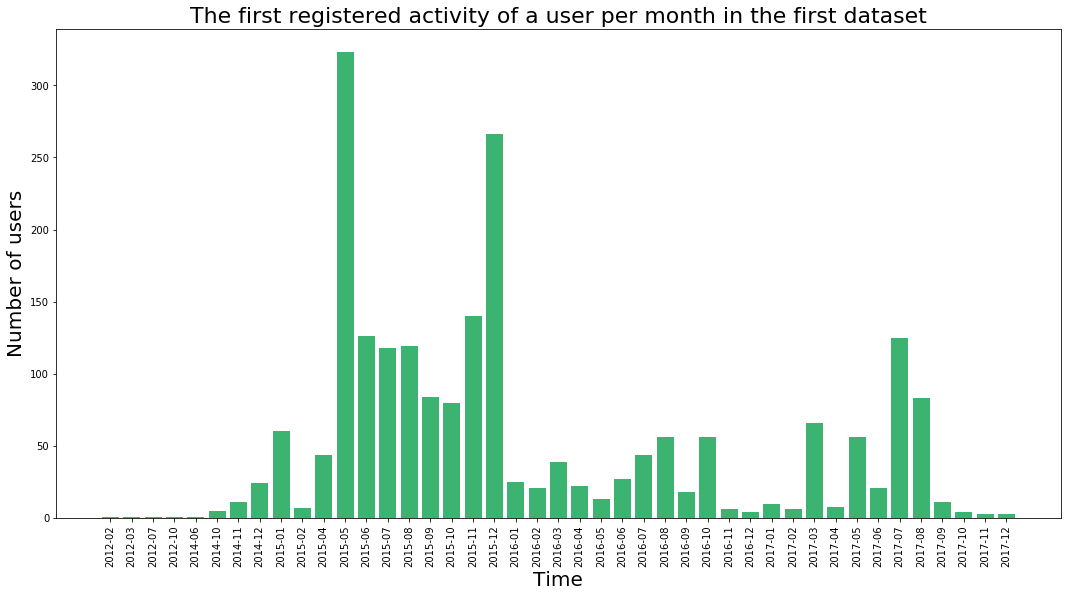

In [605]:
#Create table for first registered user activity
useropening = data1.sort_values(["author", "publish_date"])[["author", "publish_date", "account_category", "external_author_id"]].drop_duplicates(subset=["external_author_id", "author"]).drop(columns=["external_author_id"])
useropening.sort_values("publish_date")
uo = useropening["publish_date"].map(lambda x: str(x)[:7]).value_counts()

fig, ax = plt.subplots(1,1, figsize =(18,9))
Firstappearing = plt.bar(uo.index, uo, color = "#3CB371", align="center")
ax.set_xticklabels(uo.sort_index().index, rotation=90)
name_axises("The first registered activity of a user per month in the first dataset", "Time", "Number of users")

We can see here that most of the users first appeare in 2015, after the primaries had started, and with a little spike in the summer of 2017, which can explain a part of why the number of tweets increased. NB: Pay attention to the labels on the x-axis. Months with no introduction of new users are not included in this visualisation.

Why there are almost no tweets in the first dataset before november 2014 in the timeline is because there was almost none active troll users in that period. As we can see in the table provided under, the first entry of only ten users was registered before this time. Half of them was in the month before, and before that it looks sporadic with none users first entried in the year 2013.

In [507]:
earlydaysvisual = data1[data1["publish_date"] < "2014-11-01 00:00:00"][["author", "publish_date", "account_category"]].sort_values("publish_date").drop_duplicates(subset="author")
trace = go.Table(
    header=dict(values=['Author', 'Account Category', 'First entry in dataset'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[earlydaysvisual["author"], earlydaysvisual["account_category"],
                      earlydaysvisual["publish_date"]],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))
layout = dict(width=800, height=500)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')


Five of these authors were also first entried in october. Interestingly, none users in this data set had their first entry in 2013. 

Here is visualized the entries of the categories in each month:

In [604]:
#Here we make a table to count all the different entries of each user category per month.
cat_opening = useropening[["publish_date", "account_category"]]
cat_opening["publish_date"] = cat_opening["publish_date"].map(lambda x: str(x)[:7])
date_index = cat_opening[["publish_date"]].sort_values("publish_date").drop_duplicates().set_index("publish_date")
#add each category
date_index["left_count"] = cat_opening[cat_opening["account_category"] == "LeftTroll"]["publish_date"].value_counts()
date_index["right_count"] = cat_opening[cat_opening["account_category"] == "RightTroll"]["publish_date"].value_counts()
#date_index["NonEnglish_count"] = cat_opening[cat_opening["account_category"] == "NonEnglish"]["publish_date"].value_counts()
date_index["Other_count"] = cat_opening.query('account_category != "LeftTroll" & account_category != "RightTroll" & account_category != "NonEnglish" ')["publish_date"].value_counts()
date_index["Total_count"] = cat_opening["publish_date"].value_counts()
date_index = date_index.fillna(0)

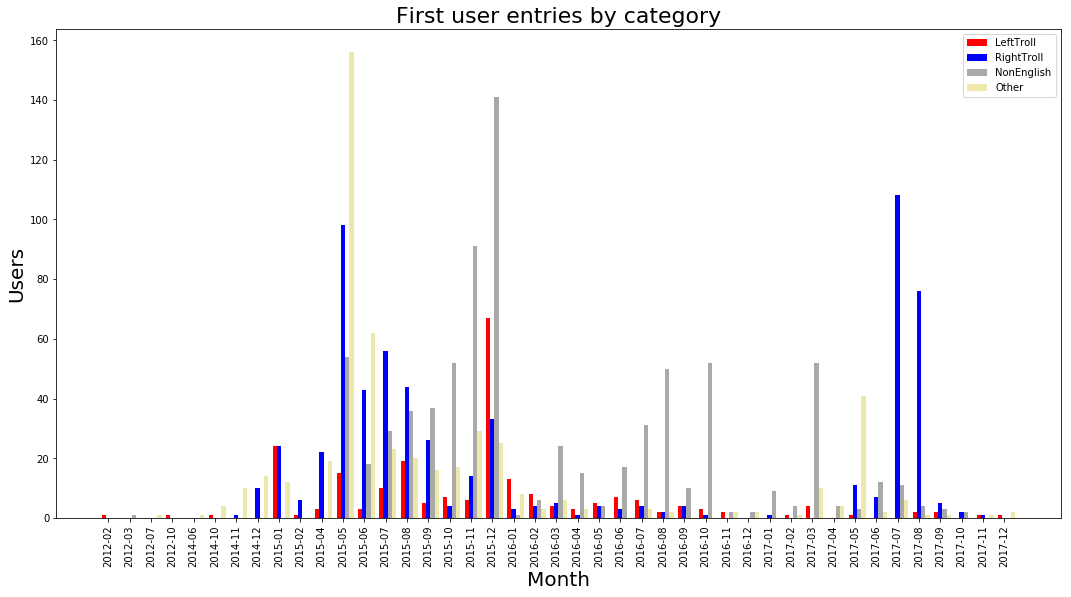

In [530]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))
ax.set_xticklabels(date_index.index, rotation=90)
ax.set_xticks(np.arange(43) + width)
width = 0.2
rects1 = ax.bar(np.arange(43), date_index["left_count"], width, color='r', label='LeftTroll')
rects2 = ax.bar(np.arange(43) + width, date_index["right_count"], width, color='b', label='RightTroll')
rects3 = ax.bar(np.arange(43) + width*2, date_index["NonEnglish_count"], width, color='darkgrey', label='NonEnglish')
rects4 = ax.bar(np.arange(43) + width*3, date_index["Other_count"] , width, color='palegoldenrod', label='Other')


ax.legend()
name_axises("First user entries by category", "Month", "Users")

Most of the accounts were created over a time period in 2015. A few spike points stand out, for example we can see that many of the "other" accounts like NewsFeed and HashtagGamer were created in May 2015. The same month had a high spike of right troll tweets, but the highest amount of Right Trolls came in the summer of 2018, leading up to the events that we mentioned earlier. 

#### 2.2.2.2 Second dataset

In the second dataset we unfortunately don't have the account categories, so there are only going to be a visualisation of each user entry per month. This one is mostly for our data story.

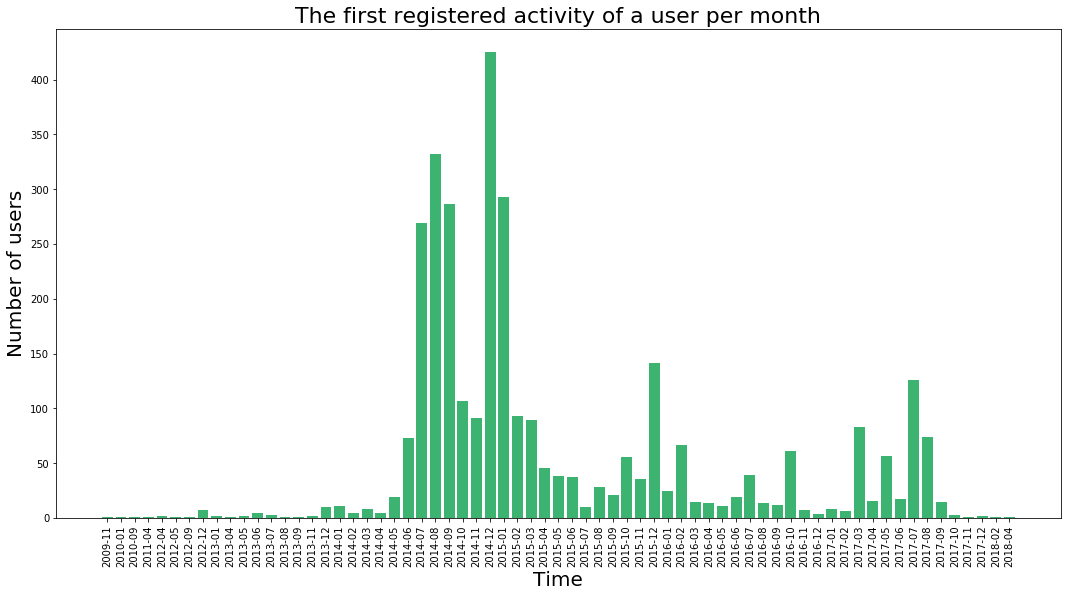

In [531]:
#Create table for first registered user activity
useropening2 = data2.sort_values(["userid", "tweet_time"])[["tweet_time", "userid"]].drop_duplicates(subset= "userid")
useropening2.sort_values("tweet_time")
uo2 = useropening2["tweet_time"].map(lambda x: str(x)[:7]).value_counts()

fig, ax = plt.subplots(1,1, figsize =(18,9))
Firstappearing = plt.bar(uo2.index, uo2, color = "#3CB371", align="center")
ax.set_xticklabels(uo2.sort_index().index, rotation=90)
name_axises("The first registered activity of a user per month", "Time", "Number of users")

In this dataset we have users being registered dating the whole way back to 2009, and also a extremely higher number of users that had their first tweets in 2014. This is the major difference between the two datasets: The number of users and tweets in 2014.

### 2.2.3 Tweets per day

What about the spread of tweets throughout a day? May it be possible to detect some irregularities regarding the time differences between Russia and USA? We asked the creators of the dataset who told us that the time stamps are all set in the US time zone.

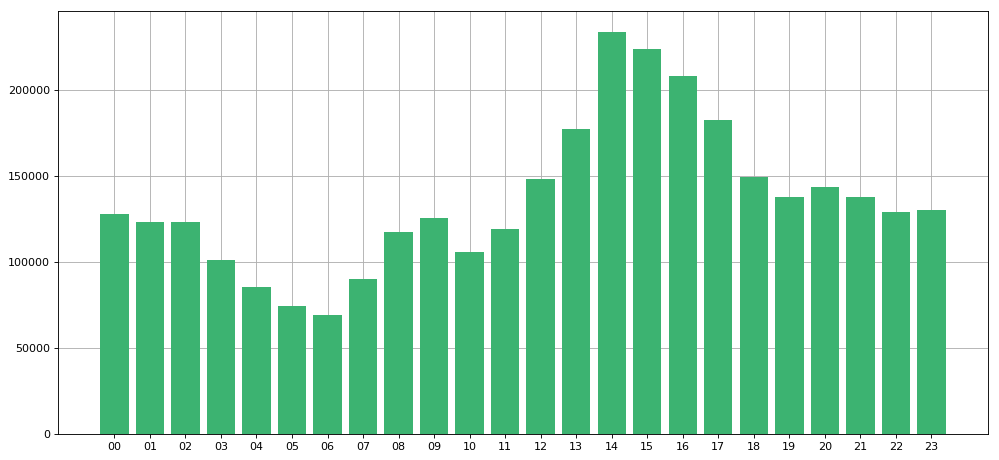

In [494]:
data2_time_of_day = data2_timesorted["tweet_time"].map(lambda x: str(x)[11:13])
data2_only_days = data2_time_of_day.value_counts().sort_index()

figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(data2_only_days.index, data2_only_days, color = "#3CB371", align="center", zorder=3)
plt.grid(zorder=0)

Here the russians have done a good job in timing the tweets. The tweets follows a good frequency regarding to when people are awake, and the majority coming in the evening(here it is necessary to think of the four different time zones in the US). The amount of tweets in especially midnight and in the early morning is a bit high, compared to actual tweet pattern through the day in the USA (https://blog.bufferapp.com/wp-content/uploads/2015/06/Buffer-social-media-science-study-US-popular-times-to-tweet-639x800.png). Regardless of this, people would probably not question this too much if some of the goals are to mimic excessively tweeting political activists, spammers or internet warriors.

### 2.2.3 Different user and category stats

We had a look at the users that got a foothold on the app and got the most followers. What kind of category has each user?

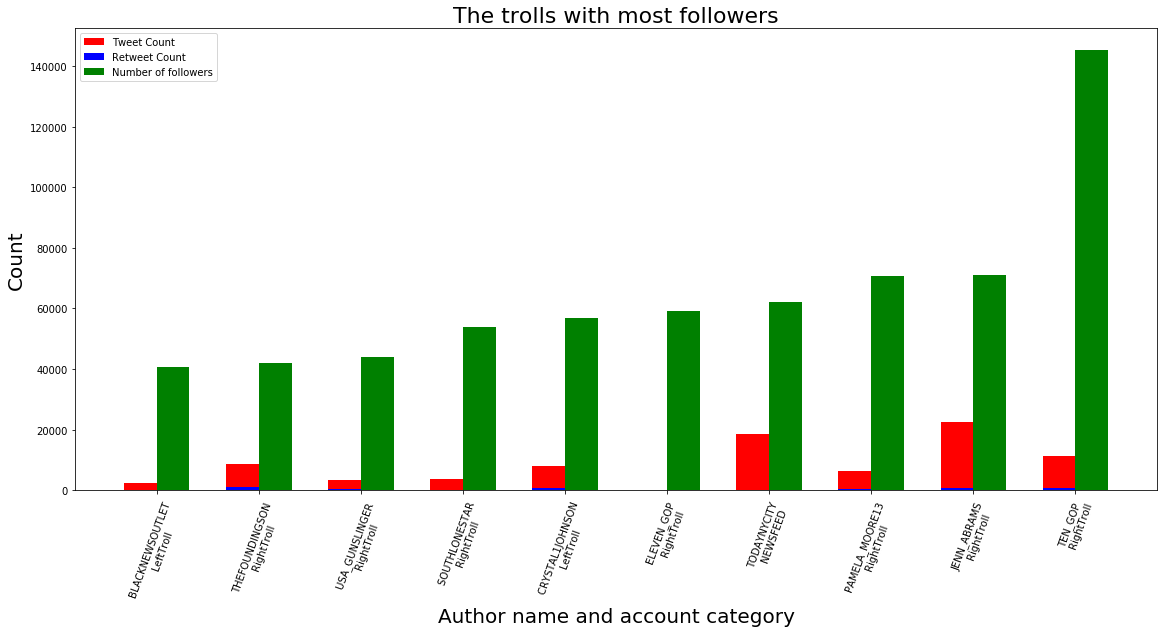

In [578]:
#display(most_pop_authors.tail(10))
fig, ax = plt.subplots(1, 1, figsize=(16,7))
width = 0.32
author_label = ["BLACKNEWSOUTLET \n LeftTroll", "THEFOUNDINGSON \n RightTroll", "USA_GUNSLINGER \n RightTroll", "SOUTHLONESTAR \n RightTroll", "CRYSTAL1JOHNSON \n LeftTroll", "ELEVEN_GOP \n RightTroll", "TODAYNYCITY \n NEWSFEED", "PAMELA_MOORE13 \n RightTroll", "JENN_ABRAMS \n RightTroll", "TEN_GOP \n RightTroll"]

rects1 = ax.bar(np.arange(10), most_pop_authors["tweet_count"].tail(10), width, color='r', label='Tweet Count')
rects1 = ax.bar(np.arange(10), most_pop_authors["retweet_count"].tail(10), width, color='b', label='Retweet Count')
rects2 = ax.bar(np.arange(10) + width, most_pop_authors["peak_followers"].tail(10), width, color='g', label='Number of followers')

#ax2 = ax.twiny()
ax2.xaxis.set_label_position('bottom')
ax2.set_xlabel(most_pop_authors.tail(10)["account_category"].tolist(), rotation=0)
ax2.spines['bottom'].set_position(('outward', 70))
ax2.set_xlim(ax.get_xlim())
plt.tight_layout()

ax.set_xticklabels(author_label, rotation=70)
ax.set_xticks(np.arange(10) + width/2)
ax.legend()
name_axises("The trolls with most followers", "Author name and account category", "Count")

We can see that many of the accounts had a huge amount of followers. In this scale it is fully possible to be viewed as a serious tweeter. The author CRYSTAL1JOHNSON for example is a LeftTroll that was frequently retweeted, for example also by Twitter's own creator, Jack Dorsey (http://uk.businessinsider.com/twitter-ceo-jack-dorsey-retweets-russian-trolls-2018-6?r=US&IR=T). Also, Donald Trump personally thanked TEN_GOP for a supporting tweet (https://twitter.com/realDonaldTrump/status/910331061409902592). This proves that the trolls can have serious influence on social media. We can also see that many of the top 10 most followed users are RightTroll, which means that this category easily has been passed on as trustworthy.

We can also see that one could get a lot of popularity regardless of being the most frequent tweeter. Popularity on Twitter is often gained by being retweeted by other popular accounts, like in the example abovementioned. In the case of ELEVEN_GOP so was this the backup account of TEN_GOP, which explains the amount of followers though having just 101 tweets.

The most popular authors does not retweet often, as we barely can see the blue retweet count in any of the top 10 authors.

We also want to take a look at the accounts that has tweeted the most. What kind of category has each user?

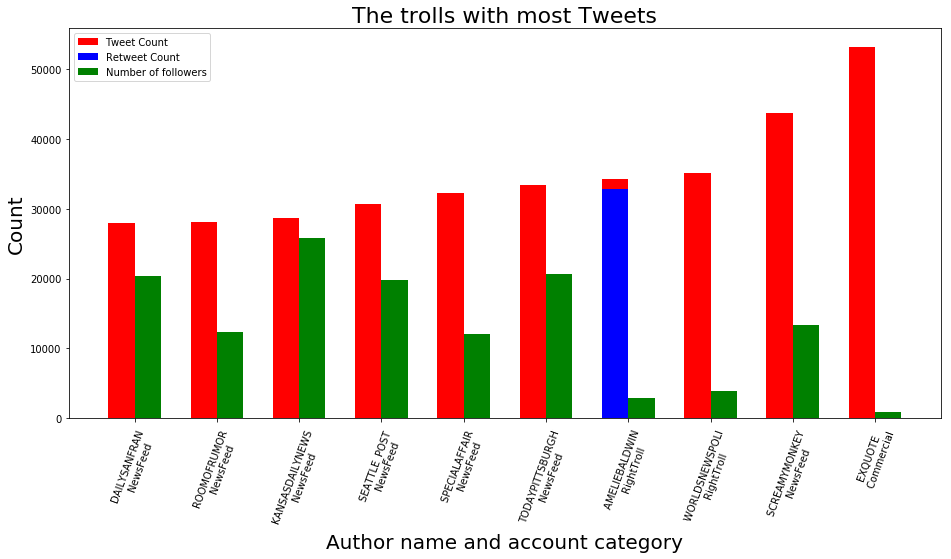

In [601]:
#display(most_active_authors.tail(10))
fig, ax = plt.subplots(1, 1, figsize=(13,6))

width = 0.32
author_label2 = ["DAILYSANFRAN \n NewsFeed", "ROOMOFRUMOR \n NewsFeed", "KANSASDAILYNEWS \n NewsFeed", "SEATTLE_POST \n NewsFeed", "SPECIALAFFAIR \n NewsFeed", "TODAYPITTSBURGH \n NewsFeed", "AMELIEBALDWIN \n RightTroll", "WORLDSNEWSPOLI \n RightTroll", "SCREAMYMONKEY \n NewsFeed", "EXQUOTE \n Commercial"]

rects1 = ax.bar(np.arange(10), most_active_authors["tweet_count"].tail(10), width, color='r', label='Tweet Count')
rects1 = ax.bar(np.arange(10), most_active_authors["retweet_count"].tail(10), width, color='b', label='Retweet Count')
rects2 = ax.bar(np.arange(10) + width, most_active_authors["peak_followers"].tail(10), width, color='g', label='Number of followers')

#ax2 = ax.twiny()
ax2.xaxis.set_label_position('bottom')
ax2.set_xlabel(most_active_authors.tail(10)["account_category"].tolist(), rotation=0)
ax2.spines['bottom'].set_position(('outward', 70))
ax2.set_xlim(ax.get_xlim())
plt.tight_layout()

ax.set_xticklabels(author_label2, rotation=70)
ax.set_xticks(np.arange(10) + width/2)
ax.legend()
name_axises("The trolls with most Tweets", "Author name and account category", "Count")


Here we can see that some of the top accounts tweets in enormous scale. Mostly of these are NewsFeed, spreading news disguised as some local institution. In most cases, the news are legitimate and links to real news sources (The tweets in their original form can still be found at (https://russiatweets.com/author). This tactic may be to invoke doubt about whether social media news channels can be seen as trustworhty, but it is hard to say for sure.

It's interesting to notice that almost none of the top 10 retweets at all, except AMELIEBALDWIN which almost exclusively retweets.

Under here, we present a table with the stats of each category. 

In [528]:
authors_count = authors_step["account_category"].value_counts().to_frame()
authors_count.loc['Total']= authors_count.sum()
authors_count["total_tweets"] = data1["account_category"].value_counts()
authors_count = authors_count.fillna(data1.shape[0])
authors_count['average'] = np.where(authors_count['account_category'] < 1, authors_count['account_category'], authors_count['total_tweets']/authors_count['account_category'])
authors_count.average = authors_count.average.astype(int)

trace = go.Table(
    header=dict(values=['Account Category', 'Total number of users', 'Total number of tweets', "Average tweets per user"],
                line = dict(color='#7D7F80'),
                fill = dict(color='#DADA47'),
                align = ['left'] * 5),
    cells=dict(values=[authors_count.index,
                      authors_count["account_category"], authors_count["total_tweets"],authors_count['average'] ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#FFFFAE'),
               align = ['left'] * 5))
layout = dict(width=800, height=500)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')


The NonEnglish category has a low amount of tweets since this table provides the english amount of tweets from these accounts. The average tweet per user is therefore average english tweet per user in just that category.

# 3) Looking into specific research questions
We found out that many of our initial research questions was harder to answer than initially thought, and that is further descripted in part 4 of this notebook. 

Questions we left out:
- Does the trolls advocate for a common political stance in each specific country? If so which leaning do they have? If not, how polarized are the tweets between left leaning and right leaning?

Questions moved to the next milestone (reasons mentioned in part 4): 
- Is there a way for people without a technical background to determine if a tweet is coming from a Russian troll?
- Which themes does the propaganda mainly revolve around? About which issues should people be particularly careful not to believe everything they read? 

Questions answered:
 
- Were the trolls united with a common political leaning in the period after the primaries in the US elections?
 
- Was the original mission of the Russian trolls for the US election to make sure that Clinton was not elected, or to get Trump elected?
 
- Are the trolls organized as a unit? Do they interact with each other (retweets, etc)?

New questions:

- How does the regions influence the different types of meddling?
  - We wanted to have a look at how the different political leanings were in the different regions. Is there any sort of tactic to each place? Mind looking at how the regions are classified in part 1.1.





### 3.1 How does the regions influence the different types of meddling?

We wish to find how the political leanings of the trolls changed by region of operation. We emphasize that our political labels only take english tweets into account. If not there would likely be several extra countries represented.

In [615]:
#We count our tweets by with account type as column, and countries as rows
categories_country=pd.DataFrame(data1_political.groupby(["region","account_category"]).size()).unstack(level=-1)
#This commented code under was used to check if authors had a distinctive region.
#pd.concat([categories_country, pd.DataFrame(data1_political.drop_duplicates(subset=["external_author_id", "author", "account_category"]).groupby(["region","account_category"]).size()).unstack(level=-1)])
categories_country.columns = categories_country.columns.droplevel()
#We add an extra row with the total amount of each account type
#reorder rows
categories_country=categories_country.filter(['RightTroll','LeftTroll',"NewsFeed"], axis=1)
#an extra column is added to sort out countries with to few political tweets
categories_country['Total'] = categories_country.sum(axis=1)
categories_country = categories_country[categories_country["Total"]>400]
categories_country.loc['Total']= categories_country.sum()
display(categories_country)



account_category,RightTroll,LeftTroll,NewsFeed,Total
region,,,,
Canada,333.0,267.0,NaN,600.0
United Kingdom,80.0,NaN,14499.0,14579.0
United States,487210.0,402076.0,573028.0,1462314.0
Unknown,208475.0,6248.0,8129.0,222852.0
Total,696098.0,408591.0,595656.0,1700345.0


We see from our dataframe that the US account for an enormous majority of the political tweets. We also see that there are a lot of political tweets with unknown origin. These two rows nearly account for the entire political dataset, while tweets originating from Canada and UK account for less then 1% combined. Unfortunately, not all of the accounts are assigned with a set, unique region. For example UK had none RightTroll accounts attached to them, which must mean that tweets from the same user suddenly changes region for a short period (The first parameter that gives region is the geolocation, and VPNs may have been used. That can make this analysis skewed.)

In order to take a closer look at the leaning of each region we plot the distribution as a stacked bar chart.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

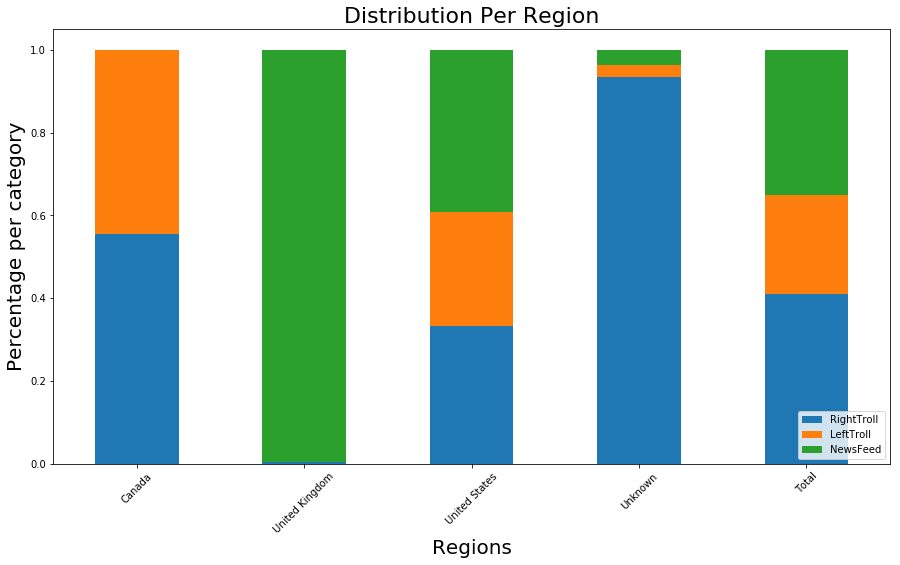

In [107]:
categories_country_distribution = categories_country.loc[:,"RightTroll":"NewsFeed"].div(categories_country["Total"], axis=0)
categories_country_distribution.plot.bar(stacked=True, figsize = (15,8))
name_axises("Distribution Per Region","Regions","Percentage per category")
plt.legend(loc=4)
plt.xticks(rotation=45)

We see that the distribution of the tweets differ from country to country. An example of this is that none of the Canadian tweets are about news, while nearly all of those of the UK are labeled as NewsFeed. From the analysis of Linvill and Warren on fivethirtyeight.com, the distributors of this dataset, they said that most of the news was actual news, with some exceptions. Some of the news feed articles were fake, and some of them linked to pro-Russia articles. 

Furthermore we see that tweets from the USA are way more evenly spread out among the categories than the other represented countries, although it is clear that the majority of tweets are labeled as "NewsFeed" and that the right leaning trolls outnumber the left trolls. Strangely nearly all of the tweets with an unknown origin are right leaning trolls. We find it strange that these tweets do not follow a distribution similar to the overall distribution of the entire set. A reason could be that these accounts find it particularly important not to be geolocated and have taken measures for this. This same reasoning could be used for the NewsFeed accounts, since many of them is named after real cities, an should have a geographic connection.

### 3.2 Did the troll activity change in regards to the american primaries?

This was one of our inital research questions. How did the activity change throughout timeline of the political landscape in the US. We are going to look at two different time periods: Before Clinton and Trump was elected as each of the two parties candidates, and after.

**Before primaries:**

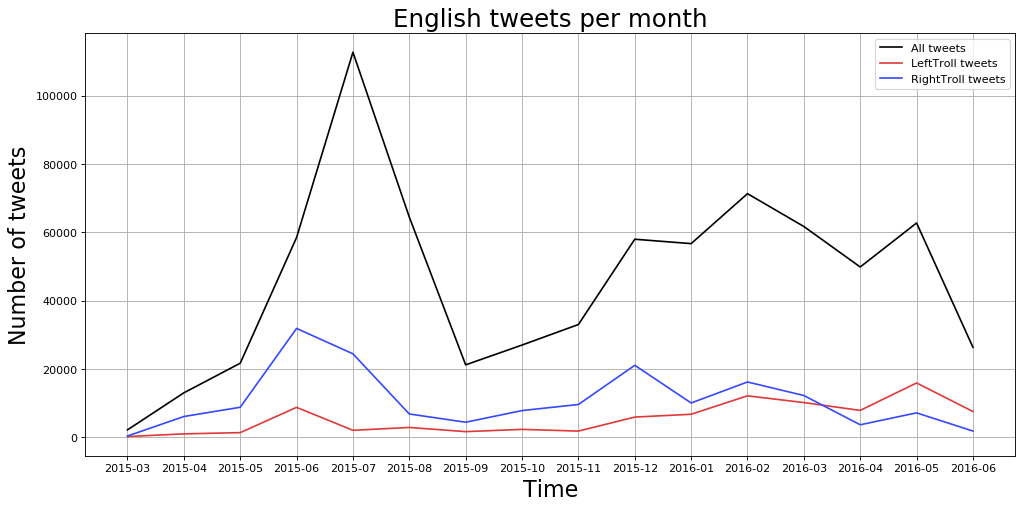

In [356]:
figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(before_primaries_time1.sort_index(), color = "#000000", zorder=3, label = "All tweets")
plt.plot(bp_left_count1.sort_index(), color = "#DE3A3A",zorder=3, label="LeftTroll tweets" )
plt.plot(bp_right_count1.sort_index(), color = "#3549FD",zorder=3, label = "RightTroll tweets")
plt.grid(zorder=0)
plt.legend()
name_axises("English tweets per month", "Time", "Number of tweets")

#figure(num=None, figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
#plt.bar(before_primaries_time1.index, before_primaries_time1, color = "#000000", zorder=3, label = "All tweets")
#plt.bar(bp_left_count1.index, bp_left_count1, color = "#DE3A3A", zorder=3, label="LeftTroll tweets")
#plt.bar(bp_right_count1.index, bp_right_count1, color = "#3549FD", zorder=3, label = "RightTroll tweets")
#plt.grid(zorder=0)
#plt.legend()
#name_axises("Tweets per month", "Time", "Number of tweets")

Things really started when the first people startet announcing their candidacy. In the beginning, after the first announced candidacy, it is almost an exponential growth of tweets. We can also see that it is a lot of tweets that are not political categorized as well. 

**After primaries**

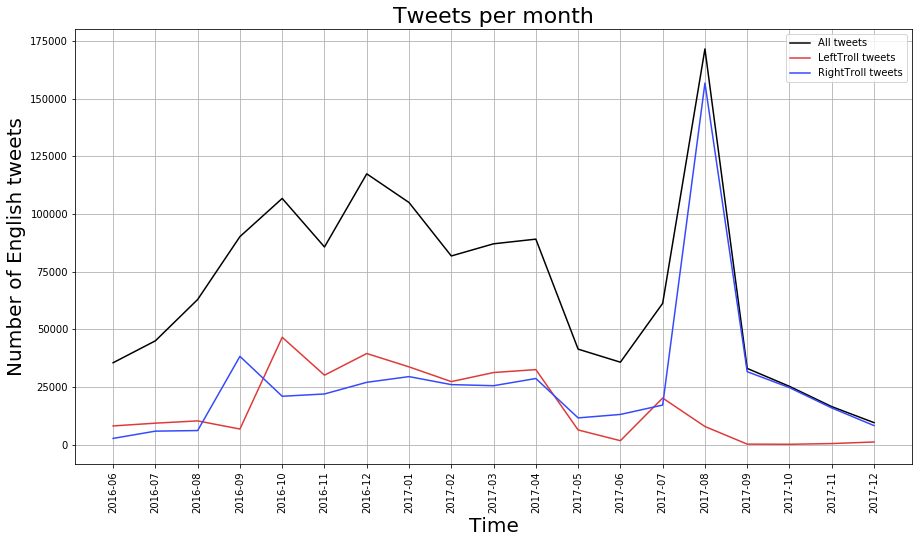

In [358]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.plot(after_primaries_time1.sort_index(), color = "#000000",zorder=3,  label = "All tweets")
plt.plot(ap_left_count1.sort_index(), color = "#DE3A3A",zorder=3, label="LeftTroll tweets" )
plt.plot(ap_right_count1.sort_index(), color = "#3549FD",zorder=3,label = "RightTroll tweets" )
plt.grid(zorder=0)
ax.set_xticklabels(after_primaries_time1.sort_index().index, rotation=90)
plt.legend()
name_axises("Tweets per month", "Time", "Number of English tweets")

#fig1, ax1 = plt.subplots(1,1, figsize=(15,8))
#plt.bar(after_primaries_time1.index, after_primaries_time1, color = "#000000", zorder=3)
#plt.bar(ap_left_count1.index, ap_left_count1, color = "#DE3A3A", zorder =3)
#plt.bar(ap_right_count1.index, ap_right_count1, color = "#3549FD", zorder =3)
#plt.grid(zorder=0)
#ax1.set_xticklabels(after_primaries_time1.sort_index().index, rotation=90)
#name_axises("Tweets per month", "Time", "Number of English tweets")

Regarding to our research question we can say that the announcements of the primaries was were the Right and Left trolls really started to appear. At this point, the IRA decided to turn their heads towards american politics. It is actually surprisingsly quiet the same month as the primaries, so the results of the primaries may not have been a significant moment as earlier thought. 

The month of the election and the period around this had a stable tweet amount from both sides. Interestingly enough, we can see that leftist tweets actually dominated until May 2017, and after that it has almost only been the activity of right trolls. Before the primaries the right tweeters were the dominating ones, but we had a whole year where there were more left than right tweets. It is hard to tell exactly why, it may have been a strategy to go harder for dividing the left side up to the election, but why left trolls kept on dominating after the election is hard to say. This may tell us that the specific strategies for the goals of Russia is not as easy to detract from the different troll categories, as it seems like it is a kind of mixed one in this phase.

From August 2017 the datasets consists almost exclusively of RightTroll tweets. From this point it seems like that they decided to shift their focus from a mixture of trolls to only fronting the right side.


### 3.3 Are the trolls interacting with each other?

**In order to answer this question we wish to inspect the content of the tweets to see if the trolls write the same tweets. If this is the case it is very likely that they operate as a unit with specific messages to share.**

,count
tweet_text,
RT @df6ab937d93fac60a3a274d6f346bd3f872eb9dec3101afea32b20007b01ef14: #ICantBreathe without Putin http://t.co/nKIlsz0PqW,241
RT @2a43e23eca4448ffca04ed734fc93ed2039e1d73da5c30ecded8bf36214f5425: Holy Christ! This #DeadHorse is scary… http://t.co/XYMeONzJ30,131
Forget about your house of cards,129
"We are what we think. All that we are arises with our thoughts. With our thoughts, we make the world.",121
"No, I'm not saying I'm sorry",117
And I'll do mine,114
Tell me would you kill to save for a life?,114
I don't belong here,113
No alarms and no surprises please,108


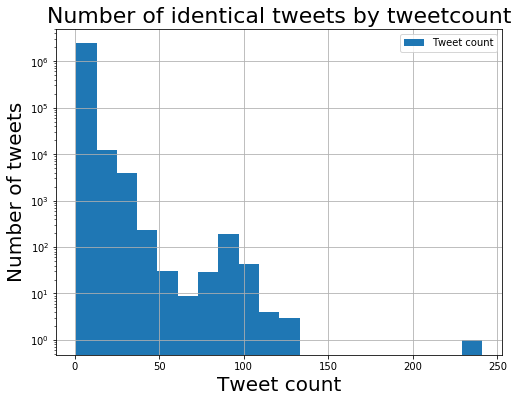

In [618]:
#Remove tweets with exact same content by the same author
without_same_tweet_author2 = data2.filter(["userid","tweet_text","post_type"]).drop_duplicates()
#Count occurences of each tweet content and sort
content_df2 = without_same_tweet_author2.groupby("tweet_text").size().to_frame()
content_df2.columns=["count"]
content_df2 = content_df2.sort_values("count",ascending=False)
#display findings
display(content_df2.head(10))
#plot the tweetcount distribution in a histogram
content_df2.hist(bins=20, figsize=(8,6), log =True, label = "Tweet count")
name_axises("Number of identical tweets by tweetcount","Tweet count","Number of tweets")
plt.legend(loc=1)

We see that there are clearly several tweets that have been tweeted several times by several people. However according to the distribution these are in an overwhelming minority compared to tweets only posted a small number of times. This indicates that they are organized to some extent, as they do have a lot of tweets with the same content independent of each other, although this is in only a small extent compared to the overall tweeting.

We are curious to see if these tweets are mainly original tweets, or if the case is that they mainly retweet the same tweets. 

In [619]:
#Count of the same content based with post type on columns
with_post_type2 = without_same_tweet_author2.groupby(["tweet_text","post_type"]).size().to_frame().unstack(level=-1)
with_post_type2.columns = with_post_type2.columns.droplevel()
#sort by common retweet and display, then do same for original tweets
with_post_type2 = with_post_type2.sort_values("RETWEET",ascending=False)
display(with_post_type2.head(10))
with_post_type2 = with_post_type2.sort_values("ORIGINAL",ascending=False)
display(with_post_type2.head(10))

post_type,ORIGINAL,QUOTE_TWEET,RETWEET
tweet_text,,,
RT @df6ab937d93fac60a3a274d6f346bd3f872eb9dec3101afea32b20007b01ef14: #ICantBreathe without Putin http://t.co/nKIlsz0PqW,NaN,NaN,241.0
RT @2a43e23eca4448ffca04ed734fc93ed2039e1d73da5c30ecded8bf36214f5425: Holy Christ! This #DeadHorse is scary… http://t.co/XYMeONzJ30,NaN,NaN,131.0
RT @marthensasser: #ColumbianChemicals The information about plant explosion had been received from the witnesses http://t.co/bYSJd0Rc7c,NaN,NaN,105.0
"RT @KevinGreen89: A terrible plant explosion happened at the #ColumbianChemicals Co in Centerville, LA",NaN,NaN,104.0
"RT @KevinGreen89: #ColumbianChemicals The explosion occured at the chemical plant located in Centerville, LA",NaN,NaN,100.0
"RT @marthensasser: The video showed the explosion at #ColumbianChemicals Co, St. Mary Parish, Louisiana appeared on the internet",NaN,NaN,99.0
"RT @marthensasser: The explosion occured at the chemical plant located in Centerville, LA #ColumbianChemicals http://t.co/azsU0ef6iz",NaN,NaN,96.0
"RT @ed8c4f95706defeec5db342e967fa202eeecab31fdef5bddb50bd38f3cba24a4: Chemical plant exploded in Centerville, Louisiana #ColumbianChemicals http://t.co/aTWhO7tINl",NaN,NaN,76.0
RT @4dc4f9360437c779e3a5b85b96681af17d4748f121cb3ec9b3b055e3988ad264: Freaking creepy #DeadHorse http://t.co/9kiqfne3ds,NaN,NaN,69.0


post_type,ORIGINAL,QUOTE_TWEET,RETWEET
tweet_text,,,
Forget about your house of cards,129.0,NaN,NaN
"We are what we think. All that we are arises with our thoughts. With our thoughts, we make the world.",121.0,NaN,NaN
"No, I'm not saying I'm sorry",117.0,NaN,NaN
And I'll do mine,114.0,NaN,NaN
Tell me would you kill to save for a life?,114.0,NaN,NaN
I don't belong here,113.0,NaN,NaN
One day maybe we'll meet again,108.0,NaN,NaN
No alarms and no surprises please,108.0,NaN,NaN
Between heaven and hell,107.0,NaN,NaN


We see from the two sorted frames that most of the tweets that occur many times are retweets. This makes sense as a retweet is by design the same tweet. The most common original tweets are a bit special. These are small lines that in themselves does not give a clear message, but rather a poetic line or sayings. These are very general statings but it is weird having so many users tweeting the same content with a significant length, which implies the usage of bots.

We find it interesting that the most common content of the trolls tweets is original tweets containing a quite complicated string that have a low likelyhood of occuring by coincidence.

In order to take a look at weether they run bots, we remove the links in the tweets and sort. If the amount of tweets with the same content increase drastically this is an indication that they run bots that re-use the description of the links

In [620]:
#we strip data on https to remove links and only keep start of tweet
stripped_data2 = without_same_tweet_author2
stripped_data2["tweet_text"]=stripped_data2["tweet_text"].apply(lambda s: str(s).split("http")[0].strip())
#we sort data by contents of the remaining part of the tweet. We then remove the top entry as this is an empty string.
stripped_data2 = stripped_data2.groupby(["tweet_text"]).size().sort_values(ascending=False).to_frame().iloc[1:]
stripped_data2.columns=["count"]
#we display the resulting tweets sorted by tweet count
display(stripped_data2.head(10))

,count
tweet_text,
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 President Trump will make America great again! #AmericaFirst #MakeAmericaGreatAgain #MAGA 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸,1223
RT @CtrlSec: Targeted #ISIS accounts,959
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 President Trump will make America great again! #AmericaFirst #MakeAmericaGreatAgain #MAGA 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸,401
#ObamaGate #ObamaWiretap IS true so 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥💥💥💥💥💥💥💥💥 🚂🚂🚂🚂,373
😎🌞☀️JAMES COMEY IS FIRED☀️🌞😎 @FBI #DrainTheSwamp #AmericaFirst #MAGA,299
RT @BraveConWarrior: ★★★ Patriots Who Dare... Join our fight to save America! ➠ Click Here,279
🚨🚨🚨🚨🚨 @NBC must take @AlecBaldwin out of @NBCSNL! #AbusiveAlec @ABFAlecBaldwin,267
RT @DJAYTIGER: Listen to the #Mashup mix #NASDOTCOM feat #NAS and #COMMON &gt;&gt;,255
Comment here on,246


Here we can see that many of the tweets after removing links are retweets, which is natural given that they contain the same content. There are also original tweets here, mostly of them leaning on being right trolls. The length of the original tweets and also the exact number of the emojis also suggests heavily usage of bots.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


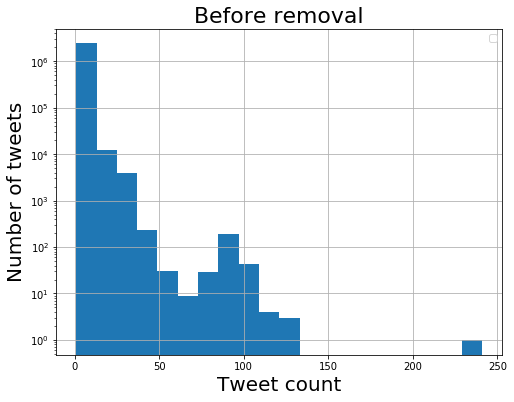

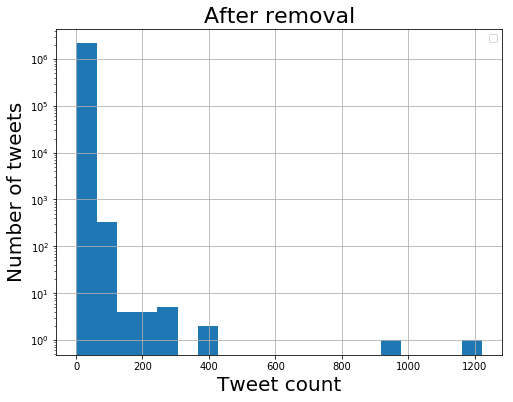

In [491]:
content_df2.hist(bins=20, figsize=(8,6), log =True)
name_axises("Before removal","Tweet count","Number of tweets")
plt.legend(loc=1)

stripped_data2.hist(bins=20, figsize=(8,6),log =True)
name_axises("After removal","Tweet count","Number of tweets")
plt.legend(loc=1)

We see that the distribution is clearly skewed towards more tweets with the same content. We conclude that the bots are organized to some extent by using bots etc. We do however suspect that they are run by the same people.

A lot of the identical tweets are retweets so we want to filter out the original content to look at the 

In [621]:
without_rts = without_same_tweet_author2[without_same_tweet_author2["post_type"] != "RETWEET"]
without_rts["tweet_text"]= without_rts["tweet_text"].apply(lambda s: str(s).split("http")[0].strip())
without_rts = without_rts.groupby(["tweet_text"]).size().sort_values(ascending=False).to_frame().iloc[1:]
without_rts.columns=["count"]
original_content = without_rts[without_rts["count"] == 1].shape[0]
reused_content = without_rts[without_rts["count"] != 1].sum().tolist()[0]
total_content = without_rts.sum().tolist()[0]

In [489]:
trace = go.Table(
    header=dict(values=['Original content appearing once', 'Original content appearing multiple times in the data set', "Total number of original content"],
                line = dict(color='#7D7F80'),
                fill = dict(color='#DADA47'),
                align = ['left'] * 5),
    cells=dict(values=[(original_content, "68,9 %"),
                      (reused_content, "31,1 %"), (total_content, "100 %")],
               line = dict(color='#7D7F80'),
               fill = dict(color='#FFFFAE'),
               align = ['left'] * 5))
layout = dict(width=800, height=500)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')


We see that the distribution is clearly skewed towards more tweets with the same content. We conclude that the bots are organized to some extent by using bots etc. We do however suspect that they are run by the same people.
Second dataset:

## Are the trolls retweeting each other ---- spark


We want to see weether the trolls communicate, and if they do: get an idea of how. 
In order to do this, we use the newer dataset as this has info about what tweets, and therefore, which users a tweet is responding to. We start by loading some of the dataframes to parquet and then read.

Py4JJavaError: An error occurred while calling o106.parquet.
: java.lang.IllegalArgumentException
	at org.apache.xbean.asm5.ClassReader.<init>(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.<init>(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.<init>(Unknown Source)
	at org.apache.spark.util.ClosureCleaner$.getClassReader(ClosureCleaner.scala:46)
	at org.apache.spark.util.FieldAccessFinder$$anon$3$$anonfun$visitMethodInsn$2.apply(ClosureCleaner.scala:449)
	at org.apache.spark.util.FieldAccessFinder$$anon$3$$anonfun$visitMethodInsn$2.apply(ClosureCleaner.scala:432)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.mutable.HashMap$$anon$1$$anonfun$foreach$2.apply(HashMap.scala:103)
	at scala.collection.mutable.HashMap$$anon$1$$anonfun$foreach$2.apply(HashMap.scala:103)
	at scala.collection.mutable.HashTable$class.foreachEntry(HashTable.scala:230)
	at scala.collection.mutable.HashMap.foreachEntry(HashMap.scala:40)
	at scala.collection.mutable.HashMap$$anon$1.foreach(HashMap.scala:103)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at org.apache.spark.util.FieldAccessFinder$$anon$3.visitMethodInsn(ClosureCleaner.scala:432)
	at org.apache.xbean.asm5.ClassReader.a(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.b(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.accept(Unknown Source)
	at org.apache.xbean.asm5.ClassReader.accept(Unknown Source)
	at org.apache.spark.util.ClosureCleaner$$anonfun$org$apache$spark$util$ClosureCleaner$$clean$14.apply(ClosureCleaner.scala:262)
	at org.apache.spark.util.ClosureCleaner$$anonfun$org$apache$spark$util$ClosureCleaner$$clean$14.apply(ClosureCleaner.scala:261)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at org.apache.spark.util.ClosureCleaner$.org$apache$spark$util$ClosureCleaner$$clean(ClosureCleaner.scala:261)
	at org.apache.spark.util.ClosureCleaner$.clean(ClosureCleaner.scala:159)
	at org.apache.spark.SparkContext.clean(SparkContext.scala:2299)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2073)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.mergeSchemasInParallel(ParquetFileFormat.scala:611)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.inferSchema(ParquetFileFormat.scala:241)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$8.apply(DataSource.scala:202)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$8.apply(DataSource.scala:202)
	at scala.Option.orElse(Option.scala:289)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:201)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:392)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:239)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:227)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:622)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:844)


**We start by counting the total number of tweets, as well as how many english tweets the dataset contains**

In [168]:
print("Total Tweets:",text.count())
print("Total English Tweets:",text.filter("tweet_language = 'en'").count())

Total Tweets: 9041308
Total English Tweets: 3261931


In [622]:
s = stats.join(s, stats.quoted_tweet_tweetid == s.t,"inner").select("in_reply_to_tweetid","quoted_tweet_tweetid",
                                                                   "retweet_tweetid")
s.show()

NameError: name 'stats' is not defined

**In order to get a sense of the extent of the communication we want to get a sense of the overall activity of the user, and therefore make a dataframe containing information of how many tweets a user has made, as well as how many times their tweets have been retweeted, replied to or quoted by other users. We also add the language of the user.**

**We will continue adding columns in order to get a complete sense of how the communication is conducted**

In [170]:
n_stats = stats.select("userid","reply_count","quote_count","retweet_count","tweetid")
summed = n_stats.groupBy("userid").agg(count("tweetid"), sum("reply_count"),sum("quote_count"),sum("retweet_count"))
summed = summed.join(users, "userid").select("userid",col("account_language").alias("language"),"count(tweetid)",
                                             "sum(retweet_count)", "sum(reply_count)","sum(quote_count)")
summed.sort(desc("sum(retweet_count)")).show(5)

+------------------+--------+--------------+------------------+----------------+----------------+
|            userid|language|count(tweetid)|sum(retweet_count)|sum(reply_count)|sum(quote_count)|
+------------------+--------+--------------+------------------+----------------+----------------+
|        4224729994|      en|         10794|           6000296|          632061|          520919|
|        4437233895|      en|          7915|           3776481|           77201|          273749|
|        4272870988|      en|          6203|           2223854|          244440|          207688|
|842368501528559616|      en|          2288|           1217081|          115617|           53697|
|905514350684844036|      en|          3067|           1171652|           27778|           94465|
+------------------+--------+--------------+------------------+----------------+----------------+
only showing top 5 rows



**We continue by adding columns for how many times a user has retweeted someone, this could be any twitter user. We also add a column stating how many times a individual twitter user has been retweeted by the trolls.**

In [183]:
#make dataframe with retweets, containing userful information
retweets = (stats.where(col("retweet_tweetid").isNotNull())).select("retweet_tweetid","retweet_userid","userid",
                                                                    col("tweetid").alias("retweeting_tweetid"))

#Find how many times a user has retweeted and add this to our user-dataframe
retweets_by_user = retweets.groupBy("userid").agg(count("*"))\
                .select(col("userid").alias("usrid"),col("count(1)").alias("retweets"))
aggregated_with_retweets = summed.join(retweets_by_user,retweets_by_user.usrid == summed.userid,"left_outer").drop("usrid")


#Make dataframe of tweets where trolls retweets other trolls
u=users.select(col("userid").alias("usrid"))
retweets_within = users.select("userid").join(retweets, "userid")
retweets_within = u.join(retweets_within, retweets_within.retweet_userid==u.usrid )\
                .select("retweet_tweetid","retweeting_tweetid","retweet_userid","userid")
    
#Make df containing number of times a user has been retweeted by trolls, and add column to user-df
retweeted_by_troll = retweets_within.groupBy("retweet_userid").agg(count("*"))\
                .select("retweet_userid",col("count(1)").alias("retweeted_by_trolls"))
aggregated_with_retweets = aggregated_with_retweets.join(retweeted_by_troll,retweeted_by_troll.retweet_userid 
                                            == aggregated_with_retweets.userid,"left_outer").drop("retweet_userid")

#Make df containing number of times a troll has retweeted other trolls, and add column to user-df
retweets_of_troll = retweets_within.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("retweets_of_troll"))
aggregated_with_retweets = aggregated_with_retweets.join(retweets_of_troll,"userid","left_outer")


**We now wish to add similar columns to see how the trolls speak to each other in the litteral sense; by replying to each other. We first add total number of replies by user, then add how many times they have been replied to, as well as how many times they themselves have replied to other trolls.**

In [191]:
#filter out everything that is not replies
replies = stats.where(col("in_reply_to_tweetid").isNotNull())\
        .select("in_reply_to_tweetid","in_reply_to_userid","userid",col("tweetid").alias("replyid"))

    
#make df with number of times each user has replied to someone, not only trolls, add this to main df.
replies_by_user = replies.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("number_of_replies"))
aggregated_with_replies = aggregated_with_retweets.join(
                replies_by_user,"userid","left_outer")

#replies from one troll to another
replies_within = u.join(replies, u.usrid == replies.in_reply_to_userid)
replies_within = replies_within.join(users,"userid").select("userid","in_reply_to_userid","replyid")
    
#add a column with how many times each user have been replied to by a troll
replies_to_user = replies_within.groupBy("in_reply_to_userid").agg(count("*"))\
                .select(col("in_reply_to_userid").alias("userid"),col("count(1)").alias("replies_by_trolls"))
aggregated_with_replies = aggregated_with_replies.join(replies_to_user,"userid","left_outer")


#make column with count of times a troll has retweeted another troll
replies_by_user = replies_within.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("replies_to_trolls"))
aggregated_with_replies = aggregated_with_replies.join(replies_by_user,"userid","left_outer")


**Now that we have information of how they retweet and reply to each other we additionally want to add information on how the trolls interact using quote tweets. In the same matter as before, we add how many times each troll have quoted someone else, how many times they quoted another troll, as well as how many times they have been quoted by other trolls.**

In [244]:
#Filter out everything that is not quotes
quotes = stats.where(col("quoted_tweet_tweetid").isNotNull())\
        .select("quoted_tweet_tweetid",col("userid").alias("quoting_userid"),col("tweetid").alias("quoteid"))

#Add column to main dataframe with how many times a troll has quoted someone
quotes_by_user = quotes.groupBy("quoting_userid").agg(count("*"))\
                .select("quoting_userid",col("count(1)").alias("quote_tweets"))
aggregated_with_quotes = aggregated_with_replies.join(quotes_by_user,quotes_by_user.quoting_userid 
                                        == aggregated_with_replies.userid,"left_outer").drop("quoting_userid")

#Creating df where troll quotes other trolls
quotes_within = stats.drop("quoted_tweet_tweetid").join(quotes, stats.tweetid == quotes.quoted_tweet_tweetid)\
                .select("quoting_userid","quoted_tweet_tweetid","quoteid",col("userid").alias("quoted_userid"))

#Add column to main dataframe with how many times a troll has been quoted by another troll
quotes_to_user = quotes_within.groupBy("quoted_userid").agg(count("*"))\
                .select("quoted_userid",col("count(1)").alias("quoted_by_trolls"))
aggregated_with_quotes = aggregated_with_quotes.join(quotes_to_user,quotes_to_user.quoted_userid 
                                                     == aggregated_with_quotes.userid,"left_outer")\
                                                    .drop("quoted_userid")

    
#Add column showing how many times each troll has quoted another troll
quotes_by_user = quotes_within.groupBy("quoting_userid").agg(count("*"))\
                .select("quoting_userid",col("count(1)").alias("quoted_a_troll"))
aggregated_with_quotes = aggregated_with_quotes.join(quotes_by_user,quotes_by_user.quoting_userid == 
                                                     aggregated_with_quotes.userid,"left_outer").drop("quoting_userid")


In [245]:
user_interactions = aggregated_with_quotes.na.fill(0)


In [246]:
interactions_df = user_interactions.toPandas().set_index("userid")
interactions_df.head(5)

,language,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,replies_to_trolls,quote_tweets,quoted_by_trolls,quoted_a_troll
userid,,,,,,,,,,,,,,
1cf2f6f6e0e87b7856deda07f1f4ba15dba59fe610283cb1379c1c4c97a00e3a,en,10,0,0,0,0,0,0,0,0,0,0,0,0
202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc462d3bb271f73e487f2b,ru,9292,764,7,0,6111,678,3226,53,2,52,0,0,0
36f2768e6fcac2041cd5604315cab62bc02c808f1ddb3492bb7b265db4875a59,en,3932,256,62,17,2263,53,322,18,1,0,44,1,3
3daea00c3d9d2530c840254c6fa6fc3c14837681269a8739a23f463b844e1c16,ru,1865,51,89,3,80,0,0,228,0,0,3,0,0
4a899897e0eeacbb0df34904b6fa75a5560c1b305051f4b86ae6652bae2738ca,en,10,0,0,0,10,0,0,0,0,0,0,0,0


In [247]:
interactions_df.groupby("language").sum()

,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,replies_to_trolls,quote_tweets,quoted_by_trolls,quoted_a_troll
language,,,,,,,,,,,,,
ar,3452,344,193,0,590,2,65,1617,8,3,162,1,0
de,102657,70081,15051,8736,12550,1316,1271,2035,359,359,1144,54,54
en,4608003,23066172,1773081,1667743,1711236,368552,305737,133147,17323,19525,157600,14064,13962
en-gb,21494,68453,3575,1561,1849,8016,599,23,456,2,1,3,0
es,285044,103021,15310,9207,860,263,256,1,0,0,10702,34,114
fr,1409,72,21,1,265,0,0,46,0,0,39,0,0
id,22966,155,68,6,0,0,0,0,0,0,1,0,0
it,13105,0,4,0,13098,0,0,0,0,0,106,0,0
ru,3953675,7940616,730729,104105,1592734,522156,592377,129339,26370,24627,18112,685,711


### Total user interactions

In [258]:
interactions_df["Total_reactions_from_trolls"] = interactions_df["retweeted_by_trolls"]+interactions_df["replies_by_trolls"]+interactions_df["quoted_by_trolls"]
interactions_df["Total_reactions_to_trolls"] = interactions_df["retweets_of_troll"]+interactions_df["replies_to_trolls"]+interactions_df["quoted_a_troll"]
interactions_df["Total_interactions"]=interactions_df["retweets"]+interactions_df["number_of_replies"]+interactions_df["quote_tweets"]
interactions_df["Total_times_interacted_with"]=(interactions_df["sum(retweet_count)"]+interactions_df["sum(reply_count)"]+interactions_df["sum(quote_count)"])
interactions_df["Ratio_reactions_to_trolls"] = interactions_df["Total_reactions_to_trolls"]/interactions_df["count(tweetid)"]
interactions_df["Ratio_reactions_from_trolls"] = interactions_df["Total_reactions_from_trolls"]/interactions_df["Total_times_interacted_with"]
interactions_df["Ratio_interaction_with_trolls"] = interactions_df["Total_reactions_to_trolls"]/interactions_df["Total_interactions"]
interactions_df = interactions_df.sort_values("Ratio_interaction_with_trolls",ascending=False)

interactions_df.head(10)

,language,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,...,quote_tweets,quoted_by_trolls,quoted_a_troll,Total_reactions_from_trolls,Total_reactions_to_trolls,Total_interactions,Ratio_reactions_to_trolls,Ratio_reactions_from_trolls,Ratio_interaction_with_trolls,Total_times_interacted_with
userid,,,,,,,,,,,,,,,,,,,,,
9517e09eeb67a37282972f2cf008232a12a599ce5668a1c576aeea2595218d4b,en,304,0,1,0,1,0,1,0,0,...,0,0,0,0,1,1,0.003289,0.000000,1.0,1
526d7c6abedfc1625aa8ef179fbcd4872ea763282668c49a17877a1cba6cbaed,en,3,0,0,0,1,0,1,0,0,...,0,0,0,0,1,1,0.333333,NaN,1.0,0
0e082da92a7b3629b1d1cd21c31f3277acf9858b7842453810a7809d6a1bf3b5,en,336,12,1,0,13,10,13,0,0,...,0,0,0,10,13,13,0.038690,0.769231,1.0,13
cc9546eafdad2af45c426b859827f5a136b6898b6fb1cfb0f5016475118960af,en,311,1,3,0,0,0,0,1,0,...,0,0,0,0,1,1,0.003215,0.000000,1.0,4
f27e9b75f38255b7e233f60a453e2d9816691de122b4275038e9347c3b7d9ddb,en,379,7,0,0,4,0,4,13,0,...,1,0,1,0,18,18,0.047493,0.000000,1.0,7
08bf215f69bdb9cb308d0266dffcd1af6bc54d214cb92fd3f740112fff23f3a9,en,430,1,2,1,1,1,1,1,0,...,0,0,0,1,2,2,0.004651,0.250000,1.0,4
9e95a4994850488485a608f87f3c4273de4b83ff58407cc9ac30ca655bca57d6,de,2,0,0,0,2,0,2,0,0,...,0,0,0,0,2,2,1.000000,NaN,1.0,0
364da4075e68fbf56ea75bf98cc92ab620aef676a6ace7c49d91e81236522bea,en,298,1,2,0,2,0,2,0,0,...,0,0,0,0,2,2,0.006711,0.000000,1.0,3
83b2b745604282d8d1415d67767762a52c148b06dc1fc2fad20d0394992c19bf,en,421,1,2,0,0,0,0,6,1,...,0,0,0,1,6,6,0.014252,0.333333,1.0,3


## visualisation

**tweet count histogram**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b110e2940>]],
      dtype=object)

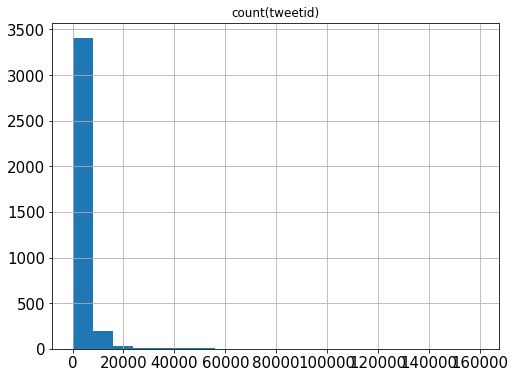

In [242]:
interactions_df[["count(tweetid)"]].hist(bins=20, figsize=(8,6), log =False, figsize = (15,9))


**Total user interactions hist**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b1059a9b0>]],
      dtype=object)

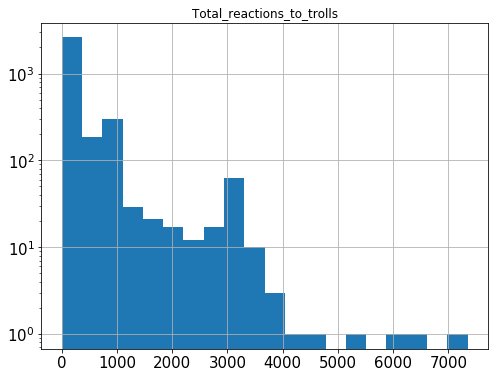

In [251]:
enough_tweets = interactions_df[interactions_df["count(tweetid)"]>10]
enough_tweets[["Total_reactions_to_trolls"]].hist(bins=20, figsize=(8,6), xlabelsize=15, ylabelsize=15, log =True)


**We see that most trolls rarely interact with users, although some of them react a whole lot to them**

### Top interacting users

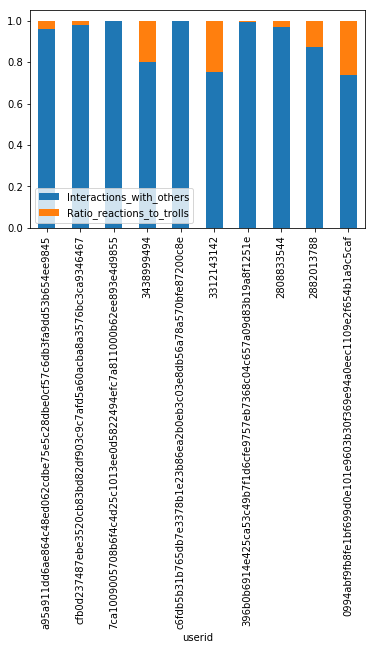

In [257]:
most_interacting = interactions_df.sort_values("Total_interactions",ascending=False).head(10)
most_interacting["Interactions_with_others"]= 1-most_interacting["Ratio_reactions_to_trolls"]
most_interacting[["Interactions_with_others","Ratio_reactions_to_trolls"]].plot.bar(stacked=True)


### Top interacted with users

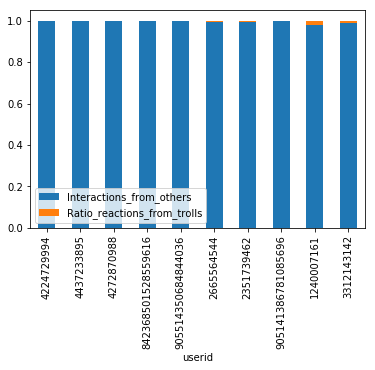

In [260]:
most_interacted_with = interactions_df.sort_values("Total_times_interacted_with",ascending=False).head(10)
most_interacted_with["Interactions_from_others"]= 1-most_interacted_with["Ratio_reactions_from_trolls"]
most_interacted_with[["Interactions_from_others","Ratio_reactions_from_trolls"]].plot.bar(stacked=True)

### Tweets by 

In [41]:
tweets_by_most_retweeting_users = most_retweeting_users.withColumnRenamed("userid","usrid")
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users\
                                .join(stats, stats.userid == most_retweeting_users.usrid)\
                        .select("userid","tweetid")
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users.groupBy("userid").agg(count('*')).\
                select("userid", col("Count(1)").alias("total_tweets")).sort(desc("total_tweets"))
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users.join(most_retweeting_users,
                                                                       tweets_by_most_retweeting_users.userid ==
                                                                      most_retweeting_users.usrid)\
                                    .select("userid","total_tweets","retweets_of_trolls")

In [39]:
tweets_by_most_retweeting_users = tweets_by_most_retweeting_users.withColumn(
                                "Percentage", (col("retweets_of_trolls") /col("total_tweets"))).sort(desc("Percentage"))

                
tweets_by_most_retweeting_users.show()

+--------------------+------------+------------------+------------------+
|              userid|total_tweets|retweets_of_trolls|        Percentage|
+--------------------+------------+------------------+------------------+
|9bd87edcd300b276a...|         119|               118|0.9915966386554622|
|9304dbfe749ac1b87...|         106|               103|0.9716981132075472|
|ed18ded2abb68f0bc...|         116|               112|0.9655172413793104|
|9f08edeb78f6dee82...|         110|               106|0.9636363636363636|
|1bed07f5349b6e10b...|         108|               104|0.9629629629629629|
|dfee299ad7755c7ac...|         107|               103|0.9626168224299065|
|9d1a1ff4e8016ea1d...|         122|               117|0.9590163934426229|
|179019db26001208f...|         124|               118|0.9516129032258065|
|f81678fb42a6bae9c...|         121|               112|0.9256198347107438|
|4584ea5091944dd0d...|         125|               114|             0.912|
|7a139f4631e610230...|         118|   

In [ ]:
print(retweeted_users.count())
print(retweeted_users.filter("retweets_by_trolls >= 10").count())
print(retweeted_users.filter("retweets_by_trolls >= 100").count())
print(retweeted_users.filter("retweets_by_trolls >= 1000").count())
print(retweeted_users.filter("retweets_by_trolls >= 10000").count())

print(retweeting_users.count())
most_retweeting_users = retweeting_users.filter("retweets_of_trolls >= 100").withColumnRenamed("userid","usrid")
print(most_retweeting_users.count())
print(retweeting_users.filter("retweets_of_trolls >= 100").count())
most_retweeting_users.show(10)

# 4) Discussion of our project so far

## 4.1) Critique of own analysis and sources of potential error

For many of our tasks it is unclear whether one can say that this is an total accurate representation of russian meddling on twitter. We only have a data sample, and it is likely that some of these accounts were taken down, given up on by IRA or by other reasons are not as active through the total period. In, it shows a general trend of the activity.

Disclaimer: Many of the visualizations still needs major improvements. Especially part 3.2 and some of the early descriptive statistics.



## 4.2) Own thoughts of milestone 2


### 4.2.1) Thoughts regarding the data sets

**First dataset:**
The first data set had some features that initally was thought to be useful that ended up not being so much, especially region and language. This encoding was not fully correct, and we therefore had to use them much more careful than earlier believed. 
**Second dataset:**

Things got a little changed when we got the possibility to work with a second data set on Sunday 18th November. The new data set featured a bunch of new interesting features, as well as not being categorized in the same manner as the first. We have not been able to look too much into it yet, but we really like the idea of combining the two and then getting more data samples. Right now, the second dataset does not have that many features, but we will be adding some more that we think will be useful for further analysing.

### 4.2.2) Dropped ideas or changed approaches to them.
**Other languages**

We worked a while on trying to analyse some of the non-english tweets, in particular the european ones. It was a significant amount, especially of the german data, but we struggled to get something in particular out of it. In general text classification became harder than initially thought. 

**General text classification** 

We was originally going to do this regarding the question how someone could determine whethter a twitter account is a troll. We knew that the TextBlob library had the application to create a sentiment, subjectivity and polarization tweets. We applied this, but when we were visualizing it we found out that it did not work as we had hoped. We found out that many of the tweets were not giving values even though there were clear indication of negative speak or positive speak. We also saw that the library struggled when tweets were particulary short. 

**Concerning traits to look for whether a user is a troll**

We found out that many of the twitter users have irregular rhytms when it comes to followers and the update of them after tweeting. Some had sudden drops of hundreds of followers and following in just a few minutes, which may imply buying of fake or real followers (or own methods of phishing to get them). Others had irregular amounts of tweets in short time span, and also some users were sharing the same rhythm of the same tweets. Unfortunately we did not have time for analysing this in whole before the end of milestone 2.


# 5) Plan for the next milestone

Visualization:
- We are not pleased with the visualization at the moment, and want to increase our quality here.
- Look for other alternatives than used right now or effectively improve those we already have.

Modeling:
- Try to create a model that could determine which category each twitter user is. This may be difficult to manage, but the idea is to split the original dataset into a training and test set and create a model that could classify the different categories. Then apply this one the new one and see if it actually has made an improvement on the dataset and could be used as an actual classifier.

Perform the analysis regarding our most important research question - "Is there a way for people without a technical background to determine if a tweet is coming from a Russian troll?":
- Analyse followers and following to look deeper into the movement of this.
- Look at the frequency and patterns of the time the tweets were tweeted.

Improving the second data set:
- Add features similar to the original data set.
- Enrich the second data set by creating similar and new subsets.
- Look more into the interaction between trolls in the new set, since we also have the user ID of each tweet.

Create the data story:
- Look for suitable tools to create our data story in.
- Extract our most important findings and present something that actually provides meaningful insight to how the russian trolls operates.
- Search for and add features unique for the data story. Animations e.g.
- Finish the data story.

Create the poster:
- Sort out the visuals that works best in paper format, and choose the most interesting results for this.
